# nami_toys

Demonstrating making toy datasets using `nami_toys`. For full reproducibility, the same seed will have to be used,

In [1]:
import torch
import matplotlib.pyplot as plt

from nami_toys import (
    Checkerboard,
    GaussianMixture,
    GaussianRing,
    GaussianShell,
    TwoMoons,
    TwoSpirals,
    Standardiser
)

## Gaussian mixture

`GaussianMixture` draws signal and background events from two multivariate normals.
The total yield is Poisson-fluctuated and the signal/background split is binomial.

In [2]:
# use 2D defaults
gauss = GaussianMixture()
print(f"dimensionality: {gauss.d}")
print(f"signal mean:    {gauss.sig_loc}")
print(f"background mean:{gauss.bkg_loc}")

dimensionality: 2
signal mean:    tensor([1., 0.])
background mean:tensor([0., 0.])


In [3]:
ds = gauss.generate(5000, sig_frac=0.3)
print(f"events: {len(ds)},  shape: {ds.x.shape},  labels: {ds.y.unique().tolist()}")
print(f"meta:   {ds.meta}")

events: 5005,  shape: torch.Size([5005, 2]),  labels: [0, 1]
meta:   {'n_expected': 5000, 'sig_frac': 0.3}


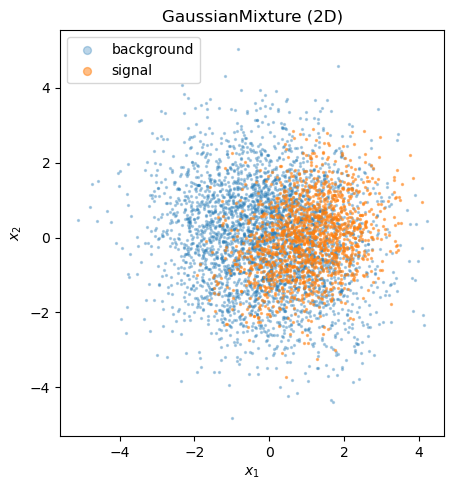

In [4]:
sig_mask = ds.y == 1
bkg_mask = ds.y == 0
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(*ds.x[bkg_mask].T, s=2, alpha=0.3, label="background")
ax.scatter(*ds.x[sig_mask].T, s=2, alpha=0.5, label="signal")
ax.set(xlabel="$x_1$", ylabel="$x_2$", title="GaussianMixture (2D)")
ax.legend(markerscale=4)
ax.set_aspect("equal")
plt.tight_layout()

### Custom covariances

You can pass custom location vectors and covariance matrices for arbitrary dimensionality to the `GaussianMixture` Dataset.

In [5]:
gauss_5d = GaussianMixture(
    sig_loc=torch.tensor([2.0, 0.0, -1.0, 0.5, 0.0]),
    sig_cov=torch.eye(5),
    bkg_loc=torch.zeros(5),
    bkg_cov=2.0 * torch.eye(5),
)
ds_5d = gauss_5d.generate(3000, sig_frac=0.5)
print(f"5-D dataset: {ds_5d.x.shape}")

5-D dataset: torch.Size([3063, 5])


## Gaussian shell

The `GaussianShell` dataset places signal events on a noisy ring and background from an isotropic 2-D Gaussian.

In [6]:
shell = GaussianShell(radius=2.5, width=0.25, bkg_scale=1.5)
ds_shell = shell.generate(5000, sig_frac=0.5)
print(f"events: {len(ds_shell)},  meta: {ds_shell.meta}")

events: 5042,  meta: {'n_expected': 5000, 'sig_frac': 0.5, 'radius': 2.5, 'width': 0.25, 'bkg_scale': 1.5}


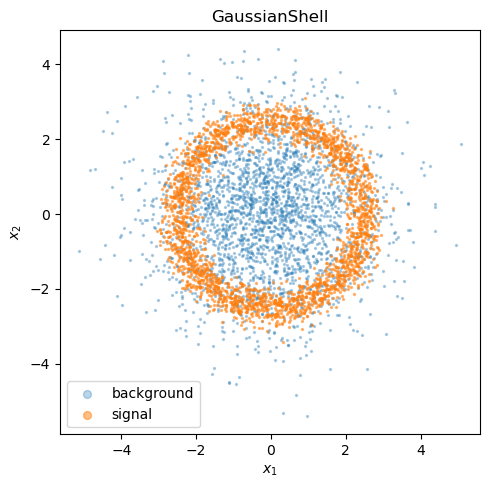

In [7]:
sig = ds_shell.y == 1
bkg = ds_shell.y == 0
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(*ds_shell.x[bkg].T, s=2, alpha=0.3, label="background")
ax.scatter(*ds_shell.x[sig].T, s=2, alpha=0.5, label="signal")
ax.set(xlabel="$x_1$", ylabel="$x_2$", title="GaussianShell")
ax.legend(markerscale=4)
ax.set_aspect("equal")
plt.tight_layout()

### Varying the signal fraction

The relative fraction of the two classes can be varied. A quick sweep over signal fractions is performed below to show how the dataset composition changes.

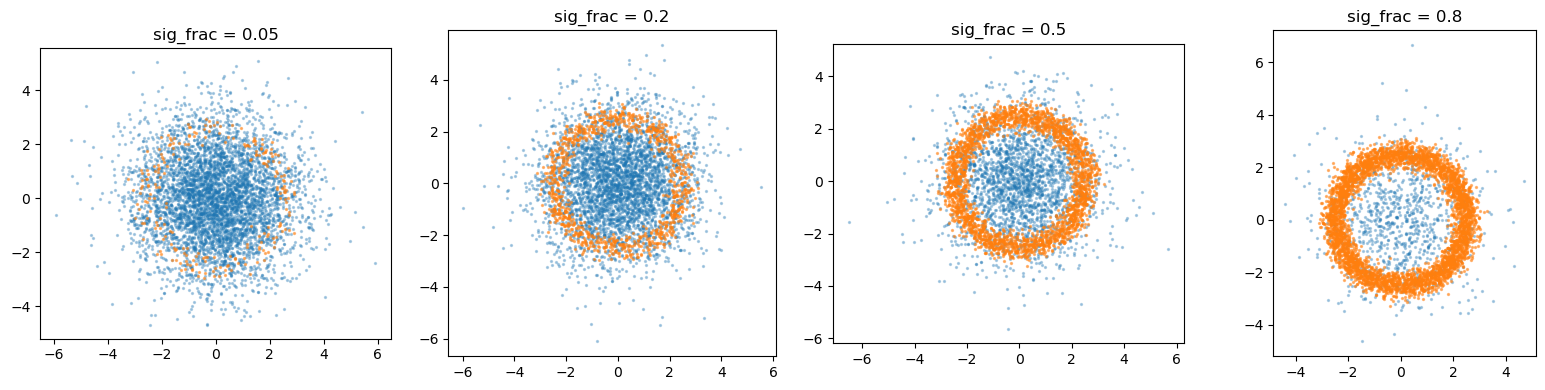

In [8]:
fracs = [0.05, 0.2, 0.5, 0.8]
fig, axes = plt.subplots(1, len(fracs), figsize=(4 * len(fracs), 4))

for ax, f in zip(axes, fracs):
    d = shell.generate(5000, sig_frac=f)
    s, b = d.y == 1, d.y == 0
    ax.scatter(*d.x[b].T, s=2, alpha=0.3)
    ax.scatter(*d.x[s].T, s=2, alpha=0.5)
    ax.set_title(f"sig_frac = {f}")
    ax.set_aspect("equal")

plt.tight_layout()

## Density benchmarks

The following toys generate samples from target densities.

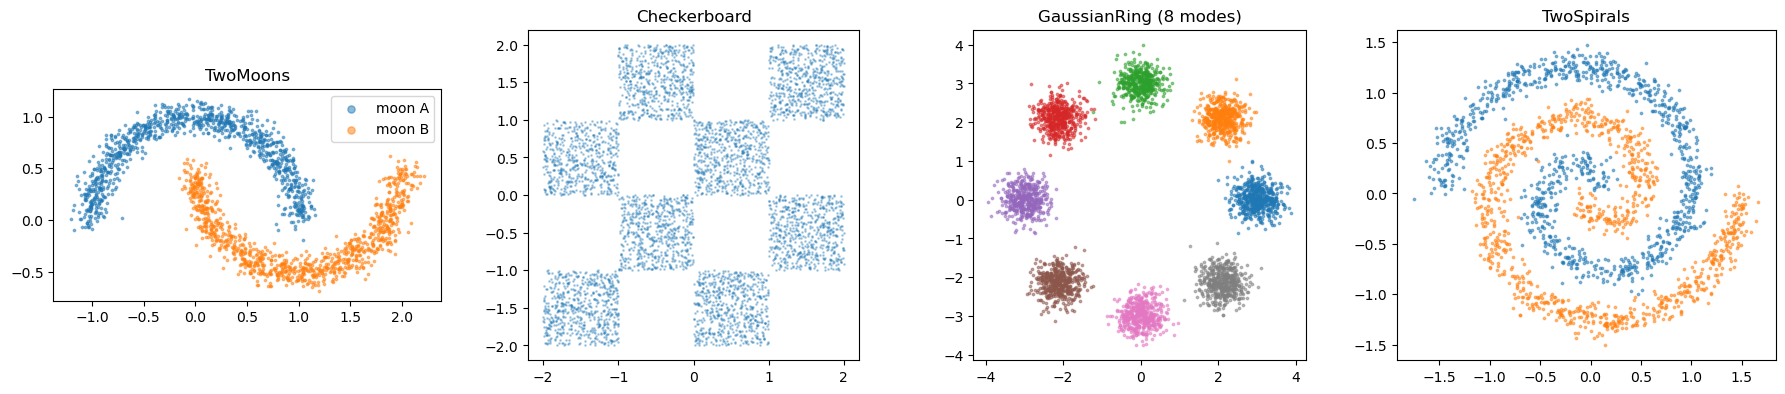

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

# two Moons
ds_moons = TwoMoons(noise=0.08).generate(2000)
for label, name in [(0, "moon A"), (1, "moon B")]:
    m = ds_moons.y == label
    axes[0].scatter(*ds_moons.x[m].T, s=3, alpha=0.5, label=name)
axes[0].set_title("TwoMoons")
axes[0].legend(markerscale=3)
axes[0].set_aspect("equal")

# checkerboard
ds_cb = Checkerboard(cells=4, bound=2.0).generate(5000)
axes[1].scatter(*ds_cb.x.T, s=1, alpha=0.3)
axes[1].set_title("Checkerboard")
axes[1].set_aspect("equal")

# ring of Gaussians
ds_ring = GaussianRing(n_modes=8, radius=3.0, std=0.3).generate(4000)
for mode in ds_ring.y.unique():
    m = ds_ring.y == mode
    axes[2].scatter(*ds_ring.x[m].T, s=3, alpha=0.5)
axes[2].set_title("GaussianRing (8 modes)")
axes[2].set_aspect("equal")

# two Spirals
ds_sp = TwoSpirals(noise=0.08, n_turns=1.5).generate(2000)
for label in [0, 1]:
    m = ds_sp.y == label
    axes[3].scatter(*ds_sp.x[m].T, s=3, alpha=0.5)
axes[3].set_title("TwoSpirals")
axes[3].set_aspect("equal")

plt.tight_layout()

## ToyDataset utilities

The `ToyDataset` container supports slicing via boolean masks and truncation.

In [10]:
# subset: keep only signal events
sig_only = ds_shell.subset(ds_shell.y == 1)
print(f"full: {len(ds_shell)},  signal only: {len(sig_only)}")

# limit: take first 200 events
small = ds_shell.limit(200)
print(f"limited: {len(small)}")

full: 5042,  signal only: 2525
limited: 200


### Feeding into a DataLoader

Since everything is already a `torch.Tensor`, wrapping in a `TensorDataset` is trivial :)

In [11]:
from torch.utils.data import DataLoader, TensorDataset

loader = DataLoader(
    TensorDataset(ds_shell.x, ds_shell.y),
    batch_size=256,
    shuffle=True,
)

x_batch, y_batch = next(iter(loader))
print(f"batch shapes: x={x_batch.shape}, y={y_batch.shape}")

batch shapes: x=torch.Size([256, 2]), y=torch.Size([256])


## Standardiser

In [15]:
## Standardiser
ds = GaussianShell().generate(5000, sig_frac=0.3)
scaler = Standardiser.fit(ds.x)
ds_z = scaler.transform_dataset(ds)    # train on ds_z.x

print(f"standardised data:  {ds_z}")

# samples_z = fm(None).sample((1000,))   # generate in standardised space
# samples = scaler.inverse(samples_z)    # back to original scale

standardised data:  ToyDataset(x=tensor([[-1.6668, -0.2294],
        [ 1.2208, -0.6667],
        [-0.1308,  0.8739],
        ...,
        [ 1.2261, -0.5603],
        [ 0.2001,  1.9676],
        [ 0.4864, -0.5509]]), y=tensor([1, 1, 0,  ..., 0, 0, 0]), meta={'n_expected': 5000, 'sig_frac': 0.3, 'radius': 2.5, 'width': 0.25, 'bkg_scale': 1.5})
